In [225]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from tqdm import trange
import pandas as pd

In [226]:
sys.path.append('/home/raffaele/Documents/ml-project/src/')

In [227]:
from torch_utility import *

## Import Dataset

In [228]:
data = np.genfromtxt('/home/raffaele/Documents/ml-project/cup/ML-CUP20-TR.csv', delimiter=',', dtype=np.float32)
X = data[:, 1:-2]
y = data[:, -2:]

In [229]:
Xtest = np.genfromtxt('/home/raffaele/Documents/ml-project/cup/ML-CUP20-TS.csv', delimiter=',', dtype=np.float32)
Xtest = Xtest[:,1:]

In [230]:
Xtest.shape

(472, 10)

In [231]:
print(X.shape)
print(y.shape)

(1524, 10)
(1524, 2)


### Split train set and Validation Set

In [232]:
Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size=0.1, random_state=42)

In [233]:
print(Xtrain.shape)
print(ytrain.shape)
print(Xval.shape)
print(yval.shape)

(1371, 10)
(1371, 2)
(153, 10)
(153, 2)


In [234]:
class Net(nn.Module):

    def __init__(self, num_units1, num_units2, activation):
        super(Net, self).__init__()
        self.activation = activation
        self.input_layer = nn.Linear(10,num_units1)
        self.hidden1 = nn.Linear(num_units1, num_units2)
        self.output = nn.Linear(num_units2,2)

    def forward(self, x):
        x = self.activation(self.input_layer(x))
        x = self.activation(self.hidden1(x))
        x = self.output(x)
        return x

In [235]:
class MEE(torch.nn.Module):

    def __init__(self):
        super(MEE, self).__init__()

    def forward(self, y_true, y_pred):
#         return torch.mean(torch.linalg.norm(y_pred - y_true))
#         return torch.mean(torch.cdist(y_true, y_pred, p=2))
        return torch.div(torch.sum(torch.pairwise_distance(y_true, y_pred)), len(y_true))
#         return torch.div(torch.linalg.norm(y_pred - y_true, ord=None), len(y_true))
#         return torch.div(torch.linalg.norm(y_pred - y_true), len(y_true))

In [236]:
from sklearn.metrics import euclidean_distances

def mean_euclidean_error(y_true, y_pred):
    assert y_true.shape == y_pred.shape
#     return np.mean(np.linalg.norm(y_pred - y_true))
#     return np.divide(np.linalg.norm(y - y_real), len(y_real))
#     return np.mean(euclidean_distances(y_true, y_pred))
    return np.mean(np.linalg.norm(y_true - y_pred, axis=1)) #utilizzare questa loss la prossima grid

In [237]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.0)

In [182]:
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping
import time

begin = time.time()
nets = []
total = []
for i in range(0,10):
    test_net = Net(100, 50, torch.sigmoid)
    test_net.apply(init_weights)
    nett = NeuralNetRegressor(test_net, max_epochs=1000,
                              lr=0.006,
                              batch_size=64,
                              optimizer=optim.SGD,
                              optimizer__momentum=0.8,
                              optimizer__weight_decay=0.0001,
                              optimizer__nesterov = True,
                              criterion=MEE,
    #                           callbacks=[EarlyStopping(patience=100)]
                             )
    # Training
    nett.fit(Xtrain, ytrain)
    nets.append(nett)
    prova = nett.predict(Xval)
    ris = mean_euclidean_error(prova, yval)
    total.append(ris)

end = time.time()
print(str(begin-end) + ' Seconds')

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       54.2491       49.0400  0.0648
      2       44.5729       36.0947  0.0593
      3       29.8418       21.7666  0.0568
      4       19.7716       17.2259  0.0547
      5       16.8307       15.8402  0.0582
      6       15.8053       15.0865  0.0544
      7       14.9757       14.0730  0.0542
      8       13.7400       12.5055  0.0614
      9       12.0189       10.6368  0.0549
     10       10.2721        9.1697  0.0552
     11        9.1930        8.5126  0.0560
     12        8.7970        8.3645  0.0553
     13        8.6744        8.3259  0.0556
     14        8.6154        8.2986  0.0559
     15        8.5728        8.2678  0.0618
     16        8.5338        8.2331  0.0608
     17        8.4954        8.1965  0.0658
     18        8.4566        8.1588  0.0559
     19        8.4167        8.1196  0.1115
     20        8.3755        8.0772  0.0704
     21        8.3307        8.0

    133        3.1268        3.2055  0.0754
    134        3.1233        3.2028  0.0511
    135        3.1199        3.2001  0.0477
    136        3.1165        3.1974  0.0446
    137        3.1131        3.1947  0.0445
    138        3.1097        3.1920  0.0445
    139        3.1063        3.1894  0.0462
    140        3.1030        3.1867  0.0463
    141        3.0996        3.1841  0.0443
    142        3.0963        3.1814  0.0538
    143        3.0930        3.1788  0.0538
    144        3.0897        3.1762  0.0491
    145        3.0865        3.1736  0.0469
    146        3.0832        3.1711  0.0461
    147        3.0800        3.1685  0.0448
    148        3.0769        3.1660  0.0454
    149        3.0737        3.1635  0.0473
    150        3.0706        3.1611  0.0466
    151        3.0675        3.1586  0.0470
    152        3.0644        3.1562  0.0838
    153        3.0614        3.1538  0.0647
    154        3.0583        3.1514  0.0543
    155        3.0553        3.1

    271        2.8095        2.9937  0.0655
    272        2.8058        3.0019  0.2020
    273        2.8056        3.0042  0.0875
    274        2.8070        2.9908  0.0410
    275        2.8015        3.0011  0.0412
    276        2.8017        3.0055  0.1512
    277        2.8033        2.9889  0.0447
    278        2.7976        2.9992  0.0426
    279        2.7976        2.9954  0.0412
    280        2.7967        2.9937  0.0497
    281        2.7934        3.0055  0.0416
    282        2.7982        2.9859  0.0414
    283        2.7911        2.9973  0.0415
    284        2.7914        2.9890  0.0427
    285        2.7898        2.9915  0.0420
    286        2.7871        3.0035  0.0446
    287        2.7916        2.9849  0.0481
    288        2.7849        2.9951  0.0857
    289        2.7850        2.9978  0.1190
    290        2.7857        2.9889  0.0409
    291        2.7812        2.9869  0.0514
    292        2.7824        2.9880  0.0548
    293        2.7782        2.9

    434        2.6523        2.9416  0.0485
    435        2.6541        2.9355  0.0414
    436        2.6519        2.9514  0.0414
    437        2.6521        2.9309  0.0815
    438        2.6497        2.9365  0.0538
    439        2.6515        2.9568  0.0542
    440        2.6508        2.9306  0.0725
    441        2.6491        2.9350  0.0418
    442        2.6474        2.9305  0.0415
    443        2.6477        2.9378  0.0460
    444        2.6457        2.9385  0.0451
    445        2.6474        2.9328  0.0482
    446        2.6463        2.9455  0.0414
    447        2.6457        2.9284  0.0409
    448        2.6438        2.9347  0.0469
    449        2.6467        2.9482  0.0410
    450        2.6436        2.9283  0.0404
    451        2.6430        2.9308  0.0423
    452        2.6411        2.9279  0.0463
    453        2.6414        2.9366  0.0852
    454        2.6399        2.9355  0.0631
    455        2.6413        2.9283  0.0416
    456        2.6405        2.9

    599        2.5688        2.8996  0.0467
    600        2.5697        2.9142  0.0899
    601        2.5699        2.9004  0.0613
    602        2.5713        2.8977  0.0473
    603        2.5680        2.9096  0.0454
    604        2.5678        2.8936  0.0494
    605        2.5635        2.9030  0.0454
    606        2.5668        2.9035  0.0444
    607        2.5665        2.9088  0.0448
    608        2.5694        2.8945  0.0493
    609        2.5623        2.8973  0.0578
    610        2.5633        2.8986  0.0472
    611        2.5602        2.8985  0.0455
    612        2.5662        2.8999  0.0514
    613        2.5630        2.9052  0.0523
    614        2.5635        2.8927  0.0466
    615        2.5589        2.8957  0.0492
    616        2.5610        2.8967  0.0439
    617        2.5596        2.8965  0.0432
    618        2.5600        2.9019  0.0416
    619        2.5611        2.8923  0.0488
    620        2.5578        2.8967  0.0414
    621        2.5569        2.9

    768        2.5078        2.8831  0.0432
    769        2.5057        2.8867  0.0415
    770        2.5077        2.9040  0.0427
    771        2.5080        2.8863  0.0489
    772        2.5065        2.8961  0.0411
    773        2.5030        2.8892  0.0415
    774        2.5060        2.8904  0.0429
    775        2.5034        2.8902  0.0450
    776        2.5060        2.8881  0.0427
    777        2.5077        2.8987  0.0412
    778        2.5019        2.8900  0.0421
    779        2.5010        2.8820  0.0423
    780        2.5014        2.8864  0.0429
    781        2.4997        2.8880  0.0416
    782        2.5011        2.8857  0.0421
    783        2.5038        2.8971  0.0423
    784        2.5014        2.8855  0.0416
    785        2.5015        2.8938  0.0414
    786        2.4987        2.8843  0.0461
    787        2.4995        2.8879  0.0415
    788        2.4991        2.8818  0.0415
    789        2.4980        2.9023  0.0485
    790        2.5008        2.8

    945        2.4471        2.8979  0.0445
    946        2.4444        2.8947  0.0421
    947        2.4482        2.9013  0.0466
    948        2.4515        2.8866  0.0431
    949        2.4428        2.8954  0.0416
    950        2.4490        2.8961  0.0417
    951        2.4442        2.8841  0.0411
    952        2.4442        2.9007  0.0417
    953        2.4478        2.8870  0.0458
    954        2.4451        2.8925  0.0525
    955        2.4398        2.8848  0.0420
    956        2.4446        2.9021  0.0644
    957        2.4472        2.8903  0.0492
    958        2.4399        2.9021  0.0422
    959        2.4484        2.8966  0.0421
    960        2.4476        2.8938  0.0514
    961        2.4418        2.8902  0.0413
    962        2.4393        2.8880  0.0425
    963        2.4413        2.8918  0.0421
    964        2.4408        2.8932  0.0433
    965        2.4440        2.8977  0.0422
    966        2.4426        2.8954  0.0483
    967        2.4386        2.8

     90        3.2865        3.3057  0.0754
     91        3.2802        3.2995  0.0462
     92        3.2739        3.2936  0.0527
     93        3.2678        3.2878  0.0419
     94        3.2618        3.2822  0.0444
     95        3.2560        3.2768  0.0687
     96        3.2502        3.2719  0.0458
     97        3.2446        3.2677  0.0427
     98        3.2391        3.2642  0.0451
     99        3.2339        3.2616  0.0428
    100        3.2288        3.2599  0.0417
    101        3.2240        3.2589  0.0490
    102        3.2194        3.2579  0.0476
    103        3.2150        3.2565  0.0416
    104        3.2104        3.2560  0.0528
    105        3.2055        3.2556  0.0429
    106        3.2016        3.2532  0.0464
    107        3.1972        3.2515  0.0421
    108        3.1930        3.2492  0.0413
    109        3.1887        3.2470  0.0427
    110        3.1845        3.2446  0.0424
    111        3.1804        3.2416  0.0424
    112        3.1764        3.2

    225        2.8685        3.0288  0.0436
    226        2.8717        3.0197  0.0419
    227        2.8650        3.0265  0.0402
    228        2.8688        3.0183  0.0412
    229        2.8616        3.0245  0.0409
    230        2.8655        3.0171  0.0406
    231        2.8585        3.0229  0.0417
    232        2.8623        3.0158  0.0474
    233        2.8554        3.0214  0.0408
    234        2.8592        3.0145  0.0416
    235        2.8524        3.0200  0.0409
    236        2.8562        3.0132  0.0426
    237        2.8494        3.0186  0.0431
    238        2.8532        3.0120  0.0693
    239        2.8465        3.0173  0.0568
    240        2.8502        3.0109  0.0426
    241        2.8435        3.0160  0.0417
    242        2.8473        3.0098  0.0409
    243        2.8407        3.0148  0.0415
    244        2.8444        3.0087  0.0427
    245        2.8378        3.0136  0.0555
    246        2.8417        3.0076  0.0682
    247        2.8350        3.0

    386        2.6920        2.9569  0.0417
    387        2.6992        2.9511  0.0491
    388        2.6902        2.9578  0.0559
    389        2.6981        2.9495  0.0570
    390        2.6891        2.9514  0.0635
    391        2.6973        2.9497  0.0464
    392        2.6874        2.9537  0.0444
    393        2.6918        2.9468  0.0442
    394        2.6865        2.9490  0.0493
    395        2.6945        2.9487  0.0424
    396        2.6846        2.9567  0.0422
    397        2.6942        2.9466  0.0474
    398        2.6838        2.9480  0.0480
    399        2.6912        2.9471  0.0486
    400        2.6821        2.9539  0.0440
    401        2.6901        2.9453  0.0434
    402        2.6812        2.9460  0.0449
    403        2.6884        2.9458  0.0417
    404        2.6795        2.9523  0.0426
    405        2.6871        2.9442  0.0486
    406        2.6788        2.9443  0.0448
    407        2.6852        2.9446  0.0441
    408        2.6771        2.9

    551        2.6070        2.9011  0.0565
    552        2.6068        2.9008  0.0418
    553        2.6068        2.9003  0.0420
    554        2.6057        2.8994  0.0530
    555        2.6061        2.9046  0.0615
    556        2.6050        2.8956  0.0470
    557        2.6046        2.8988  0.0538
    558        2.6048        2.9005  0.0501
    559        2.6049        2.9009  0.0481
    560        2.6048        2.9033  0.0435
    561        2.6044        2.8979  0.0404
    562        2.6044        2.8938  0.0410
    563        2.6033        2.8935  0.0680
    564        2.6012        2.8955  0.0423
    565        2.6029        2.9127  0.0408
    566        2.6058        2.8927  0.0411
    567        2.6015        2.8963  0.0427
    568        2.5989        2.9009  0.0413
    569        2.6006        2.9090  0.0450
    570        2.6031        2.8905  0.0562
    571        2.6000        2.8939  0.0531
    572        2.5980        2.8927  0.0465
    573        2.6005        2.9

    720        2.5454        2.8733  0.0420
    721        2.5443        2.8689  0.0533
    722        2.5475        2.8689  0.0976
    723        2.5450        2.8698  0.0449
    724        2.5441        2.8729  0.0439
    725        2.5431        2.8686  0.0461
    726        2.5462        2.8685  0.0449
    727        2.5437        2.8694  0.0415
    728        2.5428        2.8726  0.0454
    729        2.5419        2.8683  0.0575
    730        2.5449        2.8681  0.0494
    731        2.5424        2.8690  0.0474
    732        2.5415        2.8722  0.0862
    733        2.5406        2.8679  0.0417
    734        2.5436        2.8676  0.0440
    735        2.5411        2.8685  0.0426
    736        2.5402        2.8719  0.0433
    737        2.5393        2.8676  0.0422
    738        2.5424        2.8673  0.0424
    739        2.5402        2.8668  0.0467
    740        2.5389        2.8708  0.0636
    741        2.5386        2.8680  0.0471
    742        2.5413        2.8

    893        2.4891        2.8628  0.0489
    894        2.4984        2.8725  0.0541
    895        2.4913        2.8581  0.0434
    896        2.4954        2.8656  0.0470
    897        2.4872        2.8591  0.0464
    898        2.4931        2.8750  0.0492
    899        2.4897        2.8594  0.0415
    900        2.4938        2.8642  0.0413
    901        2.4879        2.8599  0.0420
    902        2.4918        2.8655  0.0419
    903        2.4874        2.8684  0.0475
    904        2.4981        2.8700  0.0417
    905        2.4869        2.8576  0.0450
    906        2.4914        2.8663  0.0490
    907        2.4851        2.8668  0.0477
    908        2.4981        2.8703  0.0479
    909        2.4866        2.8580  0.0526
    910        2.4900        2.8669  0.0428
    911        2.4839        2.8657  0.0492
    912        2.4959        2.8715  0.0770
    913        2.4856        2.8580  0.0435
    914        2.4887        2.8669  0.0408
    915        2.4827        2.8

     51        3.8116        3.8148  0.0528
     52        3.7799        3.7869  0.0460
     53        3.7499        3.7609  0.0409
     54        3.7216        3.7365  0.0531
     55        3.6948        3.7132  0.0608
     56        3.6694        3.6912  0.0507
     57        3.6454        3.6702  0.0742
     58        3.6233        3.6496  0.0446
     59        3.6027        3.6303  0.0481
     60        3.5832        3.6118  0.0637
     61        3.5645        3.5942  0.0461
     62        3.5466        3.5773  0.0434
     63        3.5295        3.5609  0.0598
     64        3.5132        3.5450  0.0436
     65        3.4973        3.5295  0.0408
     66        3.4818        3.5146  0.0412
     67        3.4668        3.5002  0.0410
     68        3.4523        3.4864  0.0449
     69        3.4382        3.4724  0.0409
     70        3.4244        3.4627  0.0410
     71        3.4135        3.4465  0.0420
     72        3.4010        3.4452  0.0413
     73        3.3927        3.4

    204        2.9151        3.0502  0.0417
    205        2.9177        3.0487  0.1187
    206        2.9138        3.0489  0.0417
    207        2.9155        3.0404  0.0446
    208        2.9078        3.0459  0.0406
    209        2.9104        3.0473  0.0408
    210        2.9064        3.0454  0.0470
    211        2.9088        3.0320  0.0489
    212        2.8992        3.0400  0.0485
    213        2.9025        3.0493  0.0420
    214        2.9046        3.0316  0.0431
    215        2.8951        3.0383  0.0414
    216        2.8985        3.0416  0.0405
    217        2.8949        3.0375  0.0407
    218        2.8965        3.0231  0.0466
    219        2.8862        3.0313  0.0584
    220        2.8901        3.0397  0.0433
    221        2.8892        3.0343  0.0614
    222        2.8901        3.0194  0.0742
    223        2.8792        3.0266  0.0533
    224        2.8829        3.0420  0.0556
    225        2.8885        3.0156  0.0409
    226        2.8739        3.0

    366        2.7092        2.9501  0.1929
    367        2.7020        2.9533  0.1695
    368        2.7017        2.9497  0.0794
    369        2.6999        2.9583  0.0802
    370        2.7022        2.9487  0.1298
    371        2.6982        2.9572  0.0420
    372        2.6989        2.9476  0.0531
    373        2.6965        2.9670  0.0908
    374        2.7049        2.9490  0.0443
    375        2.6956        2.9494  0.0410
    376        2.6957        2.9612  0.0415
    377        2.6997        2.9462  0.0420
    378        2.6931        2.9453  0.0628
    379        2.6942        2.9644  0.0469
    380        2.7013        2.9469  0.0489
    381        2.6907        2.9488  0.0658
    382        2.6910        2.9454  0.0827
    383        2.6888        2.9612  0.0495
    384        2.6931        2.9440  0.0411
    385        2.6874        2.9476  0.0533
    386        2.6880        2.9442  0.0409
    387        2.6857        2.9504  0.0406
    388        2.6869        2.9

    530        2.5961        2.9174  0.0420
    531        2.5985        2.9099  0.0411
    532        2.5934        2.9208  0.0412
    533        2.5961        2.9065  0.0416
    534        2.5932        2.9136  0.0576
    535        2.5933        2.9165  0.0449
    536        2.5968        2.9095  0.0428
    537        2.5902        2.9173  0.0473
    538        2.5926        2.9057  0.0409
    539        2.5898        2.9132  0.0417
    540        2.5900        2.9142  0.0409
    541        2.5941        2.9062  0.0415
    542        2.5880        2.9183  0.0411
    543        2.5877        2.9028  0.0444
    544        2.5898        2.9143  0.0415
    545        2.5869        2.9094  0.0433
    546        2.5865        2.9139  0.0655
    547        2.5917        2.9055  0.0438
    548        2.5846        2.9138  0.0444
    549        2.5837        2.9099  0.0472
    550        2.5845        2.9083  0.0473
    551        2.5885        2.9122  0.0746
    552        2.5820        2.9

    698        2.5197        2.8823  0.0423
    699        2.5231        2.8919  0.0412
    700        2.5161        2.8810  0.0478
    701        2.5191        2.8852  0.0415
    702        2.5208        2.8812  0.0418
    703        2.5168        2.8829  0.0770
    704        2.5180        2.8982  0.0411
    705        2.5236        2.8796  0.0933
    706        2.5165        2.8967  0.0452
    707        2.5151        2.8811  0.0523
    708        2.5165        2.8841  0.0408
    709        2.5152        2.8822  0.0583
    710        2.5163        2.8826  0.0653
    711        2.5134        2.8865  0.0695
    712        2.5177        2.8844  0.0458
    713        2.5137        2.8850  0.0536
    714        2.5157        2.8775  0.0431
    715        2.5119        2.8807  0.0452
    716        2.5143        2.8839  0.0532
    717        2.5147        2.8919  0.0453
    718        2.5116        2.8865  0.0415
    719        2.5130        2.8808  0.0409
    720        2.5105        2.8

    869        2.4575        2.8807  0.0454
    870        2.4581        2.8684  0.0458
    871        2.4611        2.8734  0.0683
    872        2.4558        2.8714  0.0438
    873        2.4570        2.8841  0.0413
    874        2.4576        2.8703  0.0474
    875        2.4597        2.8788  0.0431
    876        2.4537        2.8741  0.0461
    877        2.4566        2.8681  0.0431
    878        2.4564        2.8742  0.0594
    879        2.4551        2.8708  0.0514
    880        2.4548        2.8719  0.0415
    881        2.4524        2.8676  0.0419
    882        2.4554        2.8814  0.0449
    883        2.4537        2.8689  0.0421
    884        2.4543        2.8745  0.0568
    885        2.4510        2.8730  0.0547
    886        2.4535        2.8718  0.0437
    887        2.4506        2.8686  0.0428
    888        2.4533        2.8717  0.0417
    889        2.4499        2.8773  0.0417
    890        2.4495        2.8667  0.0418
    891        2.4516        2.8

     32        7.4160        7.1013  0.0427
     33        7.2561        6.9453  0.0466
     34        7.0817        6.7765  0.0403
     35        6.8934        6.5956  0.0450
     36        6.6928        6.4045  0.0406
     37        6.4821        6.2047  0.0417
     38        6.2624        5.9990  0.0409
     39        6.0353        5.7857  0.0408
     40        5.8024        5.5668  0.0407
     41        5.5653        5.3453  0.0459
     42        5.3272        5.1253  0.0414
     43        5.0949        4.9151  0.0431
     44        4.8823        4.7245  0.0414
     45        4.6976        4.5595  0.0419
     46        4.5390        4.4266  0.0419
     47        4.4064        4.3197  0.0417
     48        4.2975        4.2338  0.0486
     49        4.2088        4.1625  0.0413
     50        4.1335        4.1043  0.0405
     51        4.0686        4.0510  0.0408
     52        4.0114        4.0002  0.0412
     53        3.9613        3.9547  0.0464
     54        3.9172        3.9

    166        2.9883        3.1008  0.0450
    167        2.9857        3.0989  0.0423
    168        2.9832        3.0971  0.0410
    169        2.9806        3.0952  0.0405
    170        2.9781        3.0934  0.0440
    171        2.9757        3.0917  0.0421
    172        2.9732        3.0899  0.0414
    173        2.9707        3.0881  0.0418
    174        2.9683        3.0864  0.0428
    175        2.9659        3.0847  0.0416
    176        2.9634        3.0830  0.0482
    177        2.9610        3.0813  0.0421
    178        2.9586        3.0796  0.0429
    179        2.9562        3.0779  0.0477
    180        2.9538        3.0762  0.0413
    181        2.9515        3.0745  0.0489
    182        2.9491        3.0728  0.0473
    183        2.9467        3.0712  0.0424
    184        2.9444        3.0695  0.0442
    185        2.9421        3.0679  0.0474
    186        2.9397        3.0662  0.0512
    187        2.9374        3.0646  0.0413
    188        2.9351        3.0

    313        2.7490        2.9741  0.0508
    314        2.7436        2.9671  0.0453
    315        2.7436        2.9678  0.0482
    316        2.7413        2.9741  0.0443
    317        2.7450        2.9701  0.0442
    318        2.7401        2.9676  0.0450
    319        2.7397        2.9674  0.0454
    320        2.7376        2.9712  0.0534
    321        2.7408        2.9700  0.0706
    322        2.7361        2.9665  0.0483
    323        2.7357        2.9661  0.0515
    324        2.7338        2.9675  0.0554
    325        2.7362        2.9694  0.0480
    326        2.7323        2.9659  0.0464
    327        2.7317        2.9665  0.0556
    328        2.7304        2.9676  0.0563
    329        2.7316        2.9686  0.0463
    330        2.7283        2.9622  0.0465
    331        2.7270        2.9653  0.0465
    332        2.7286        2.9687  0.0519
    333        2.7279        2.9654  0.0442
    334        2.7265        2.9591  0.0570
    335        2.7235        2.9

    473        2.6282        2.9288  0.0440
    474        2.6275        2.9185  0.0416
    475        2.6253        2.9235  0.0408
    476        2.6262        2.9173  0.0601
    477        2.6264        2.9288  0.0480
    478        2.6249        2.9196  0.0410
    479        2.6262        2.9257  0.0422
    480        2.6238        2.9174  0.0409
    481        2.6235        2.9215  0.0410
    482        2.6229        2.9302  0.0437
    483        2.6221        2.9157  0.0433
    484        2.6228        2.9258  0.0416
    485        2.6209        2.9143  0.0459
    486        2.6205        2.9284  0.0414
    487        2.6203        2.9158  0.0472
    488        2.6188        2.9294  0.0592
    489        2.6191        2.9132  0.0526
    490        2.6175        2.9219  0.0483
    491        2.6179        2.9144  0.0565
    492        2.6164        2.9207  0.0421
    493        2.6160        2.9221  0.0416
    494        2.6166        2.9145  0.0433
    495        2.6153        2.9

    636        2.5512        2.8943  0.0478
    637        2.5517        2.8992  0.0414
    638        2.5515        2.8877  0.0412
    639        2.5511        2.8922  0.0426
    640        2.5495        2.8933  0.0412
    641        2.5502        2.8992  0.0417
    642        2.5500        2.8875  0.0416
    643        2.5496        2.8917  0.0425
    644        2.5478        2.8922  0.0415
    645        2.5486        2.8989  0.0415
    646        2.5484        2.8873  0.0411
    647        2.5474        2.8893  0.0422
    648        2.5467        2.8906  0.0414
    649        2.5454        2.8929  0.0416
    650        2.5457        2.8909  0.0407
    651        2.5448        2.8966  0.0497
    652        2.5448        2.8899  0.0416
    653        2.5464        2.8885  0.0413
    654        2.5459        2.8894  0.0422
    655        2.5430        2.8978  0.0423
    656        2.5426        2.8871  0.0416
    657        2.5436        2.8984  0.0411
    658        2.5417        2.8

    805        2.4912        2.8809  0.0585
    806        2.4922        2.8934  0.0434
    807        2.4914        2.8801  0.0426
    808        2.4911        2.8884  0.1360
    809        2.4908        2.8844  0.0406
    810        2.4908        2.8810  0.0427
    811        2.4911        2.8844  0.0419
    812        2.4901        2.8854  0.0427
    813        2.4878        2.8850  0.0427
    814        2.4891        2.8874  0.0430
    815        2.4885        2.8781  0.0527
    816        2.4862        2.8824  0.0409
    817        2.4893        2.8903  0.0413
    818        2.4892        2.8852  0.0432
    819        2.4866        2.8865  0.0593
    820        2.4893        2.8793  0.0476
    821        2.4847        2.8829  0.0427
    822        2.4878        2.8847  0.0415
    823        2.4850        2.8825  0.0476
    824        2.4857        2.8825  0.0410
    825        2.4847        2.8834  0.0415
    826        2.4859        2.8848  0.0426
    827        2.4823        2.8

    982        2.4394        2.8727  0.0425
    983        2.4341        2.8830  0.0464
    984        2.4366        2.8784  0.0414
    985        2.4362        2.8819  0.0461
    986        2.4367        2.8802  0.0417
    987        2.4349        2.8852  0.0509
    988        2.4355        2.8801  0.0794
    989        2.4345        2.8813  0.0522
    990        2.4359        2.8743  0.0533
    991        2.4315        2.8846  0.0490
    992        2.4348        2.8817  0.0581
    993        2.4323        2.8802  0.0540
    994        2.4376        2.8925  0.0564
    995        2.4349        2.8772  0.0413
    996        2.4326        2.8751  0.0416
    997        2.4284        2.8991  0.0415
    998        2.4396        2.8755  0.0447
    999        2.4322        2.8752  0.0446
   1000        2.4283        2.8987  0.0414
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       53.3306       47.1046  0.0422
      2       41.6814       32.3

    120        3.1481        3.2328  0.0428
    121        3.1447        3.2299  0.0404
    122        3.1413        3.2271  0.0489
    123        3.1379        3.2242  0.0538
    124        3.1346        3.2213  0.0435
    125        3.1313        3.2184  0.0474
    126        3.1280        3.2155  0.0430
    127        3.1247        3.2126  0.0418
    128        3.1214        3.2096  0.0499
    129        3.1181        3.2067  0.0439
    130        3.1149        3.2037  0.0556
    131        3.1117        3.2007  0.0767
    132        3.1085        3.1977  0.0433
    133        3.1053        3.1947  0.0757
    134        3.1022        3.1910  0.0431
    135        3.0985        3.1922  0.0437
    136        3.0973        3.1844  0.0434
    137        3.0916        3.1886  0.0946
    138        3.0921        3.1793  0.0731
    139        3.0858        3.1797  0.0410
    140        3.0844        3.1761  0.0538
    141        3.0807        3.1750  0.0414
    142        3.0784        3.1

    261        2.8266        3.0082  0.1776
    262        2.8272        2.9928  0.0420
    263        2.8160        2.9974  0.0602
    264        2.8183        2.9919  0.2104
    265        2.8131        2.9950  0.0631
    266        2.8156        2.9902  0.1524
    267        2.8099        2.9933  0.0571
    268        2.8129        2.9887  0.0865
    269        2.8070        2.9918  0.1762
    270        2.8101        2.9872  0.1913
    271        2.8041        2.9904  0.2058
    272        2.8074        2.9859  0.1772
    273        2.8013        2.9891  0.1145
    274        2.8048        2.9846  0.2067
    275        2.7986        2.9878  0.1952
    276        2.8020        2.9834  0.1900
    277        2.7959        2.9864  0.1680
    278        2.7990        2.9823  0.2290
    279        2.7932        2.9851  0.2891
    280        2.7962        2.9812  0.1241
    281        2.7905        2.9838  0.0473
    282        2.7936        2.9798  0.1759
    283        2.7879        2.9

    419        2.6606        2.9169  0.0431
    420        2.6619        2.9081  0.0400
    421        2.6593        2.9134  0.0399
    422        2.6617        2.9075  0.0417
    423        2.6576        2.9259  0.0416
    424        2.6645        2.9071  0.0421
    425        2.6566        2.9147  0.0411
    426        2.6578        2.9051  0.0466
    427        2.6555        2.9110  0.0420
    428        2.6578        2.9049  0.0405
    429        2.6537        2.9231  0.0409
    430        2.6599        2.9045  0.0754
    431        2.6527        2.9124  0.1103
    432        2.6539        2.9024  0.0430
    433        2.6517        2.9087  0.0414
    434        2.6539        2.9024  0.0426
    435        2.6499        2.9197  0.0487
    436        2.6552        2.9022  0.0416
    437        2.6489        2.9106  0.0415
    438        2.6505        2.8996  0.0412
    439        2.6480        2.9064  0.0493
    440        2.6490        2.9004  0.0413
    441        2.6462        2.9

    584        2.5729        2.8522  0.0430
    585        2.5729        2.8519  0.0772
    586        2.5685        2.8539  0.0408
    587        2.5718        2.8517  0.0927
    588        2.5714        2.8511  0.0801
    589        2.5670        2.8532  0.0970
    590        2.5708        2.8511  0.0447
    591        2.5699        2.8504  0.0414
    592        2.5655        2.8535  0.0410
    593        2.5696        2.8508  0.1394
    594        2.5688        2.8498  0.0405
    595        2.5642        2.8521  0.0463
    596        2.5684        2.8545  0.1304
    597        2.5674        2.8551  0.1458
    598        2.5649        2.8436  0.1224
    599        2.5635        2.8511  0.1220
    600        2.5643        2.8457  0.1644
    601        2.5628        2.8521  0.1478
    602        2.5642        2.8443  0.0551
    603        2.5624        2.8555  0.0664
    604        2.5641        2.8491  0.0627
    605        2.5655        2.8448  0.0511
    606        2.5603        2.8

    755        2.5024        2.8280  0.1836
    756        2.5045        2.8287  0.0508
    757        2.5021        2.8285  0.0560
    758        2.5062        2.8281  0.0492
    759        2.5031        2.8289  0.0572
    760        2.5050        2.8278  0.0431
    761        2.5010        2.8281  0.0759
    762        2.5054        2.8322  0.0410
    763        2.4995        2.8283  0.0440
    764        2.5011        2.8278  0.2051
    765        2.4989        2.8305  0.2131
    766        2.5030        2.8276  0.0765
    767        2.4987        2.8280  0.0481
    768        2.5000        2.8270  0.0496
    769        2.4988        2.8266  0.1079
    770        2.5000        2.8280  0.0567
    771        2.4975        2.8280  0.0483
    772        2.5000        2.8273  0.0425
    773        2.4973        2.8268  0.2004
    774        2.4995        2.8267  0.1899
    775        2.4959        2.8276  0.0713
    776        2.4989        2.8268  0.0452
    777        2.4957        2.8

    926        2.4514        2.8379  0.0490
    927        2.4533        2.8230  0.0411
    928        2.4528        2.8276  0.0421
    929        2.4488        2.8316  0.0430
    930        2.4500        2.8234  0.0538
    931        2.4528        2.8233  0.0869
    932        2.4497        2.8326  0.0460
    933        2.4486        2.8228  0.0438
    934        2.4509        2.8296  0.0415
    935        2.4462        2.8260  0.0432
    936        2.4490        2.8238  0.0525
    937        2.4467        2.8224  0.0631
    938        2.4471        2.8230  0.0672
    939        2.4462        2.8293  0.0421
    940        2.4490        2.8222  0.0431
    941        2.4455        2.8229  0.0478
    942        2.4470        2.8230  0.0514
    943        2.4448        2.8301  0.0545
    944        2.4514        2.8240  0.0500
    945        2.4444        2.8251  0.0494
    946        2.4454        2.8222  0.0437
    947        2.4443        2.8324  0.0686
    948        2.4504        2.8

     76        3.3575        3.3813  0.1423
     77        3.3495        3.3726  0.1261
     78        3.3417        3.3644  0.0417
     79        3.3337        3.3567  0.0452
     80        3.3260        3.3495  0.0426
     81        3.3186        3.3428  0.0406
     82        3.3116        3.3363  0.0413
     83        3.3047        3.3298  0.0442
     84        3.2980        3.3235  0.0436
     85        3.2914        3.3174  0.0484
     86        3.2850        3.3114  0.0534
     87        3.2788        3.3055  0.0438
     88        3.2726        3.2999  0.0439
     89        3.2666        3.2943  0.0417
     90        3.2607        3.2889  0.0425
     91        3.2549        3.2837  0.0428
     92        3.2492        3.2786  0.0430
     93        3.2436        3.2738  0.0421
     94        3.2383        3.2692  0.0774
     95        3.2333        3.2650  0.0481
     96        3.2279        3.2777  0.1099
     97        3.2262        3.2937  0.0611
     98        3.2247        3.2

    213        2.9039        3.0479  0.0511
    214        2.9021        3.0468  0.0741
    215        2.9002        3.0456  0.0432
    216        2.8984        3.0445  0.0429
    217        2.8966        3.0434  0.0445
    218        2.8948        3.0423  0.0421
    219        2.8930        3.0411  0.0409
    220        2.8912        3.0400  0.0476
    221        2.8894        3.0389  0.0414
    222        2.8877        3.0379  0.0441
    223        2.8859        3.0368  0.0418
    224        2.8842        3.0357  0.0408
    225        2.8824        3.0347  0.0424
    226        2.8807        3.0336  0.0416
    227        2.8790        3.0326  0.0525
    228        2.8773        3.0315  0.0403
    229        2.8756        3.0305  0.0434
    230        2.8739        3.0295  0.0412
    231        2.8723        3.0285  0.0480
    232        2.8706        3.0275  0.0412
    233        2.8689        3.0266  0.0406
    234        2.8673        3.0256  0.0421
    235        2.8656        3.0

    365        2.7077        2.9521  0.0477
    366        2.7132        2.9424  0.0494
    367        2.7060        2.9510  0.0407
    368        2.7114        2.9415  0.0414
    369        2.7043        2.9499  0.0467
    370        2.7096        2.9406  0.0426
    371        2.7026        2.9488  0.0555
    372        2.7079        2.9397  0.0612
    373        2.7009        2.9477  0.0411
    374        2.7061        2.9389  0.0582
    375        2.6991        2.9467  0.0419
    376        2.7042        2.9382  0.0445
    377        2.6974        2.9456  0.0545
    378        2.7024        2.9375  0.0520
    379        2.6958        2.9445  0.0416
    380        2.7007        2.9368  0.0408
    381        2.6942        2.9435  0.0413
    382        2.6990        2.9362  0.1369
    383        2.6926        2.9425  0.0410
    384        2.6973        2.9355  0.0503
    385        2.6910        2.9415  0.0511
    386        2.6956        2.9349  0.0417
    387        2.6895        2.9

    523        2.6078        2.9003  0.0428
    524        2.6063        2.8955  0.0409
    525        2.6121        2.8937  0.0412
    526        2.6047        2.8966  0.0418
    527        2.6065        2.8995  0.0412
    528        2.6046        2.8974  0.0407
    529        2.6117        2.8927  0.0459
    530        2.6027        2.8961  0.0413
    531        2.6044        2.8984  0.0478
    532        2.6025        2.8968  0.0407
    533        2.6097        2.8918  0.0407
    534        2.6007        2.8952  0.0483
    535        2.6022        2.8973  0.0410
    536        2.6003        2.8969  0.0441
    537        2.6077        2.8910  0.0472
    538        2.5987        2.8947  0.0406
    539        2.6003        2.8962  0.0414
    540        2.5979        2.8978  0.0416
    541        2.6063        2.8903  0.0412
    542        2.5967        2.8941  0.0518
    543        2.5982        2.8951  0.0445
    544        2.5956        2.8942  0.0521
    545        2.6032        2.8

    689        2.5334        2.8674  0.0475
    690        2.5305        2.8656  0.0780
    691        2.5309        2.8812  0.0454
    692        2.5374        2.8715  0.0727
    693        2.5294        2.8778  0.0461
    694        2.5402        2.8665  0.0463
    695        2.5307        2.8696  0.0586
    696        2.5265        2.8674  0.0941
    697        2.5308        2.8675  0.0588
    698        2.5284        2.8652  0.0510
    699        2.5268        2.8678  0.0566
    700        2.5311        2.8710  0.0469
    701        2.5270        2.8673  0.0486
    702        2.5301        2.8694  0.0567
    703        2.5241        2.8682  0.0513
    704        2.5293        2.8667  0.1009
    705        2.5258        2.8799  0.0522
    706        2.5287        2.8646  0.0770
    707        2.5247        2.8660  0.0827
    708        2.5280        2.8662  0.0656
    709        2.5226        2.8643  0.0469
    710        2.5248        2.8695  0.0473
    711        2.5253        2.8

    861        2.4757        2.8637  0.0472
    862        2.4797        2.8665  0.0472
    863        2.4751        2.8639  0.0708
    864        2.4798        2.8685  0.0533
    865        2.4746        2.8636  0.0447
    866        2.4785        2.8664  0.0479
    867        2.4740        2.8638  0.0462
    868        2.4787        2.8687  0.0589
    869        2.4735        2.8635  0.0528
    870        2.4773        2.8663  0.0468
    871        2.4729        2.8638  0.0541
    872        2.4776        2.8688  0.0565
    873        2.4725        2.8635  0.0622
    874        2.4761        2.8662  0.0555
    875        2.4718        2.8637  0.0532
    876        2.4764        2.8689  0.0535
    877        2.4715        2.8635  0.0535
    878        2.4750        2.8661  0.0471
    879        2.4707        2.8637  0.0701
    880        2.4752        2.8690  0.0629
    881        2.4704        2.8636  0.0503
    882        2.4739        2.8661  0.0463
    883        2.4696        2.8

     25        8.2227        7.9319  0.0439
     26        8.1627        7.8700  0.0419
     27        8.0942        7.8001  0.0416
     28        8.0158        7.7206  0.0416
     29        7.9263        7.6302  0.0437
     30        7.8247        7.5283  0.0416
     31        7.7100        7.4148  0.0465
     32        7.5819        7.2895  0.0420
     33        7.4406        7.1525  0.0418
     34        7.2862        7.0060  0.0418
     35        7.1195        6.8483  0.0516
     36        6.9417        6.6805  0.0417
     37        6.7540        6.5038  0.0441
     38        6.5580        6.3190  0.0418
     39        6.3555        6.1276  0.0420
     40        6.1473        5.9304  0.0418
     41        5.9337        5.7261  0.0427
     42        5.7153        5.5200  0.0436
     43        5.4924        5.3084  0.0414
     44        5.2660        5.0938  0.0431
     45        5.0420        4.8831  0.0462
     46        4.8270        4.6821  0.0426
     47        4.6294        4.5

    160        3.0212        3.1275  0.0475
    161        3.0183        3.1252  0.0414
    162        3.0154        3.1228  0.0413
    163        3.0125        3.1205  0.0430
    164        3.0097        3.1182  0.0429
    165        3.0069        3.1159  0.0411
    166        3.0041        3.1137  0.0418
    167        3.0014        3.1115  0.0423
    168        2.9986        3.1093  0.0419
    169        2.9959        3.1072  0.0427
    170        2.9932        3.1051  0.0426
    171        2.9906        3.1030  0.0525
    172        2.9879        3.1010  0.0435
    173        2.9853        3.0990  0.0414
    174        2.9827        3.0970  0.0422
    175        2.9802        3.0951  0.0417
    176        2.9776        3.0932  0.0443
    177        2.9751        3.0913  0.0425
    178        2.9726        3.0894  0.0576
    179        2.9702        3.0876  0.0429
    180        2.9677        3.0858  0.0434
    181        2.9653        3.0841  0.0437
    182        2.9629        3.0

    307        2.7668        2.9665  0.0468
    308        2.7608        2.9705  0.0416
    309        2.7648        2.9657  0.0411
    310        2.7589        2.9695  0.0426
    311        2.7629        2.9650  0.0492
    312        2.7569        2.9685  0.0412
    313        2.7609        2.9642  0.0430
    314        2.7550        2.9674  0.0414
    315        2.7590        2.9635  0.0502
    316        2.7531        2.9662  0.0414
    317        2.7574        2.9623  0.0415
    318        2.7511        2.9650  0.0414
    319        2.7554        2.9613  0.0419
    320        2.7488        2.9658  0.0422
    321        2.7537        2.9601  0.0480
    322        2.7472        2.9623  0.0413
    323        2.7482        2.9744  0.0420
    324        2.7547        2.9760  0.0416
    325        2.7510        2.9585  0.0412
    326        2.7430        2.9653  0.0418
    327        2.7465        2.9580  0.0512
    328        2.7413        2.9621  0.0414
    329        2.7433        2.9

    469        2.6373        2.9179  0.0457
    470        2.6402        2.9525  0.0411
    471        2.6492        2.9182  0.0413
    472        2.6379        2.9230  0.0425
    473        2.6370        2.9171  0.0414
    474        2.6383        2.9497  0.0415
    475        2.6462        2.9174  0.0416
    476        2.6359        2.9225  0.0463
    477        2.6347        2.9168  0.0413
    478        2.6362        2.9482  0.0412
    479        2.6436        2.9166  0.0472
    480        2.6337        2.9222  0.0424
    481        2.6326        2.9157  0.0422
    482        2.6341        2.9463  0.0477
    483        2.6404        2.9159  0.0472
    484        2.6317        2.9216  0.0402
    485        2.6307        2.9143  0.0415
    486        2.6318        2.9432  0.0418
    487        2.6367        2.9153  0.0419
    488        2.6301        2.9210  0.0414
    489        2.6298        2.9217  0.0419
    490        2.6288        2.9339  0.0426
    491        2.6383        2.9

    634        2.5699        2.8994  0.0438
    635        2.5690        2.8994  0.0424
    636        2.5691        2.9072  0.0489
    637        2.5697        2.8926  0.0412
    638        2.5673        2.9013  0.0415
    639        2.5694        2.9029  0.0413
    640        2.5674        2.8962  0.0417
    641        2.5681        2.8917  0.0414
    642        2.5672        2.9005  0.0420
    643        2.5678        2.8955  0.0413
    644        2.5660        2.9084  0.0417
    645        2.5691        2.8915  0.0421
    646        2.5660        2.9126  0.0415
    647        2.5699        2.8944  0.0414
    648        2.5645        2.8947  0.0477
    649        2.5642        2.8933  0.0454
    650        2.5646        2.9217  0.0411
    651        2.5751        2.8936  0.0415
    652        2.5643        2.8962  0.0417
    653        2.5662        2.8918  0.0433
    654        2.5641        2.9026  0.0416
    655        2.5675        2.8987  0.0425
    656        2.5638        2.9

    808        2.5212        2.8824  0.0431
    809        2.5157        2.8948  0.0444
    810        2.5139        2.8921  0.0414
    811        2.5220        2.8839  0.0417
    812        2.5144        2.8866  0.0505
    813        2.5137        2.8870  0.0429
    814        2.5167        2.8854  0.0415
    815        2.5142        2.8843  0.0419
    816        2.5124        2.8873  0.0422
    817        2.5109        2.8887  0.0423
    818        2.5194        2.8814  0.0413
    819        2.5137        2.8963  0.0490
    820        2.5150        2.8824  0.0414
    821        2.5125        2.8866  0.0420
    822        2.5097        2.8910  0.0429
    823        2.5162        2.8838  0.0416
    824        2.5110        2.8919  0.0419
    825        2.5125        2.8814  0.0410
    826        2.5120        2.8846  0.0415
    827        2.5083        2.8832  0.0471
    828        2.5105        2.9066  0.0418
    829        2.5188        2.8819  0.0422
    830        2.5102        2.8

    985        2.4667        2.8902  0.0508
    986        2.4682        2.8955  0.0415
    987        2.4651        2.8866  0.0419
    988        2.4655        2.9037  0.0424
    989        2.4657        2.8902  0.0419
    990        2.4657        2.9019  0.0419
    991        2.4651        2.8905  0.0489
    992        2.4674        2.8943  0.0423
    993        2.4620        2.8868  0.0441
    994        2.4643        2.8889  0.0415
    995        2.4598        2.8878  0.0416
    996        2.4635        2.8894  0.0417
    997        2.4598        2.8860  0.0431
    998        2.4614        2.9007  0.0421
    999        2.4641        2.8957  0.0425
   1000        2.4623        2.8866  0.0433
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       53.3190       46.9187  0.0391
      2       41.0597       31.0260  0.0407
      3       25.1381       19.2251  0.0407
      4       18.0276       16.3143  0.0422
      5       16.1221       15.3

    122        3.1140        3.2024  0.0446
    123        3.1106        3.1997  0.0495
    124        3.1073        3.1970  0.0411
    125        3.1040        3.1944  0.0417
    126        3.1007        3.1917  0.0418
    127        3.0974        3.1890  0.0412
    128        3.0942        3.1864  0.0414
    129        3.0910        3.1837  0.0408
    130        3.0878        3.1810  0.0440
    131        3.0847        3.1783  0.0410
    132        3.0816        3.1756  0.0417
    133        3.0784        3.1729  0.0407
    134        3.0751        3.1703  0.0413
    135        3.0723        3.1674  0.0412
    136        3.0689        3.1657  0.0417
    137        3.0662        3.1631  0.0415
    138        3.0636        3.1607  0.0442
    139        3.0608        3.1584  0.0419
    140        3.0582        3.1560  0.0428
    141        3.0555        3.1536  0.0414
    142        3.0529        3.1513  0.0427
    143        3.0502        3.1490  0.0466
    144        3.0475        3.1

    255        2.8355        3.0179  0.0428
    256        2.8344        3.0162  0.0421
    257        2.8328        3.0173  0.0434
    258        2.8320        3.0142  0.0410
    259        2.8300        3.0174  0.0413
    260        2.8297        3.0120  0.0411
    261        2.8272        3.0178  0.0433
    262        2.8273        3.0106  0.0407
    263        2.8246        3.0168  0.0412
    264        2.8245        3.0096  0.0418
    265        2.8222        3.0156  0.0480
    266        2.8220        3.0086  0.0411
    267        2.8199        3.0144  0.0415
    268        2.8195        3.0076  0.0416
    269        2.8176        3.0132  0.0410
    270        2.8171        3.0065  0.0414
    271        2.8154        3.0121  0.0413
    272        2.8147        3.0054  0.0412
    273        2.8132        3.0111  0.0412
    274        2.8124        3.0042  0.0417
    275        2.8111        3.0102  0.0517
    276        2.8101        3.0031  0.0439
    277        2.8089        3.0

    407        2.6932        2.9464  0.0433
    408        2.6920        2.9517  0.0410
    409        2.6918        2.9464  0.0412
    410        2.6910        2.9490  0.0415
    411        2.6904        2.9447  0.0411
    412        2.6893        2.9495  0.0512
    413        2.6889        2.9442  0.0411
    414        2.6881        2.9473  0.0469
    415        2.6876        2.9428  0.0417
    416        2.6865        2.9477  0.0445
    417        2.6862        2.9437  0.0412
    418        2.6859        2.9461  0.0414
    419        2.6850        2.9416  0.0424
    420        2.6839        2.9454  0.0411
    421        2.6835        2.9401  0.0415
    422        2.6824        2.9450  0.0415
    423        2.6820        2.9402  0.0412
    424        2.6816        2.9437  0.0418
    425        2.6809        2.9389  0.0416
    426        2.6798        2.9434  0.0419
    427        2.6793        2.9384  0.0416
    428        2.6789        2.9422  0.0417
    429        2.6781        2.9

    561        2.6053        2.9102  0.0457
    562        2.6007        2.9052  0.0409
    563        2.6021        2.9043  0.0413
    564        2.6021        2.9117  0.0411
    565        2.6018        2.9038  0.0475
    566        2.6023        2.9062  0.0408
    567        2.6003        2.9022  0.0407
    568        2.5984        2.9085  0.0414
    569        2.6004        2.9108  0.0412
    570        2.6009        2.9030  0.0406
    571        2.5975        2.9050  0.0476
    572        2.5975        2.9056  0.0480
    573        2.5983        2.9045  0.0414
    574        2.5963        2.9061  0.0425
    575        2.5963        2.9167  0.0414
    576        2.5990        2.9029  0.0411
    577        2.5945        2.9042  0.0414
    578        2.5948        2.9028  0.0411
    579        2.5936        2.9151  0.0415
    580        2.5975        2.9021  0.0428
    581        2.5926        2.9039  0.0414
    582        2.5929        2.9021  0.0411
    583        2.5921        2.9

    727        2.5325        2.8974  0.0446
    728        2.5305        2.8988  0.0429
    729        2.5335        2.8998  0.0423
    730        2.5301        2.8972  0.0430
    731        2.5330        2.9045  0.0425
    732        2.5295        2.8973  0.0419
    733        2.5302        2.9104  0.0422
    734        2.5318        2.8949  0.0429
    735        2.5298        2.8958  0.0431
    736        2.5277        2.8956  0.0416
    737        2.5293        2.9060  0.0421
    738        2.5313        2.8960  0.0436
    739        2.5275        2.8973  0.0444
    740        2.5266        2.8960  0.0419
    741        2.5274        2.8984  0.0420
    742        2.5270        2.9016  0.0427
    743        2.5295        2.9002  0.0495
    744        2.5269        2.8964  0.0414
    745        2.5257        2.9040  0.0412
    746        2.5252        2.9006  0.0424
    747        2.5272        2.8958  0.0444
    748        2.5248        2.8981  0.0431
    749        2.5246        2.8

    901        2.4813        2.9099  0.0429
    902        2.4863        2.8799  0.0447
    903        2.4793        2.8919  0.0441
    904        2.4784        2.8875  0.0421
    905        2.4813        2.8834  0.0420
    906        2.4777        2.8843  0.0417
    907        2.4797        2.8976  0.0418
    908        2.4807        2.8842  0.0420
    909        2.4751        2.8864  0.0416
    910        2.4799        2.9070  0.0443
    911        2.4824        2.8791  0.0415
    912        2.4764        2.8913  0.0414
    913        2.4766        2.8923  0.0422
    914        2.4813        2.8813  0.0477
    915        2.4751        2.8833  0.0410
    916        2.4777        2.9052  0.0422
    917        2.4798        2.8807  0.0410
    918        2.4734        2.8859  0.0420
    919        2.4783        2.8998  0.0422
    920        2.4791        2.8783  0.0427
    921        2.4734        2.8900  0.0422
    922        2.4747        2.8842  0.0420
    923        2.4760        2.9

     56        3.7675        3.7756  0.0425
     57        3.7392        3.7499  0.0412
     58        3.7124        3.7254  0.0421
     59        3.6872        3.7022  0.0407
     60        3.6632        3.6805  0.0413
     61        3.6412        3.6597  0.0457
     62        3.6202        3.6398  0.0410
     63        3.6002        3.6211  0.0412
     64        3.5815        3.6034  0.0413
     65        3.5634        3.5869  0.0427
     66        3.5464        3.5716  0.0410
     67        3.5304        3.5654  0.0490
     68        3.5170        3.5399  0.0415
     69        3.5001        3.5319  0.0406
     70        3.4879        3.5146  0.0411
     71        3.4734        3.5037  0.0410
     72        3.4608        3.4892  0.0424
     73        3.4477        3.4777  0.0410
     74        3.4355        3.4657  0.0413
     75        3.4236        3.4542  0.0423
     76        3.4123        3.4429  0.0420
     77        3.4014        3.4318  0.0412
     78        3.3909        3.4

    191        2.9377        3.0631  0.0431
    192        2.9324        3.0648  0.0411
    193        2.9334        3.0593  0.0504
    194        2.9276        3.0619  0.0408
    195        2.9292        3.0561  0.0412
    196        2.9232        3.0591  0.0461
    197        2.9250        3.0530  0.0445
    198        2.9188        3.0564  0.0420
    199        2.9208        3.0497  0.0418
    200        2.9144        3.0537  0.0423
    201        2.9167        3.0463  0.0435
    202        2.9101        3.0510  0.0415
    203        2.9126        3.0429  0.0413
    204        2.9058        3.0484  0.0415
    205        2.9085        3.0397  0.0429
    206        2.9017        3.0458  0.0416
    207        2.9045        3.0367  0.0420
    208        2.8976        3.0433  0.0413
    209        2.9006        3.0338  0.0414
    210        2.8937        3.0410  0.0414
    211        2.8968        3.0310  0.0417
    212        2.8898        3.0387  0.0415
    213        2.8930        3.0

    347        2.7186        2.9710  0.0442
    348        2.7260        2.9627  0.0418
    349        2.7164        2.9610  0.0414
    350        2.7158        2.9600  0.0410
    351        2.7150        2.9698  0.0410
    352        2.7226        2.9616  0.0410
    353        2.7129        2.9585  0.0418
    354        2.7129        2.9584  0.0495
    355        2.7118        2.9673  0.0423
    356        2.7189        2.9601  0.0416
    357        2.7095        2.9569  0.0411
    358        2.7094        2.9597  0.0416
    359        2.7084        2.9663  0.0413
    360        2.7151        2.9585  0.0411
    361        2.7066        2.9547  0.0413
    362        2.7064        2.9611  0.0414
    363        2.7061        2.9575  0.0415
    364        2.7046        2.9558  0.0415
    365        2.7035        2.9621  0.0417
    366        2.7101        2.9564  0.0415
    367        2.7025        2.9539  0.0417
    368        2.7014        2.9548  0.0457
    369        2.7003        2.9

    509        2.6158        2.9195  0.0424
    510        2.6178        2.9284  0.0416
    511        2.6194        2.9129  0.0421
    512        2.6126        2.9062  0.0413
    513        2.6138        2.9195  0.0420
    514        2.6142        2.9064  0.0416
    515        2.6112        2.9181  0.0415
    516        2.6118        2.9152  0.0489
    517        2.6155        2.9240  0.0414
    518        2.6149        2.9109  0.0417
    519        2.6099        2.9115  0.0410
    520        2.6115        2.9065  0.0423
    521        2.6085        2.9064  0.0413
    522        2.6080        2.9220  0.0412
    523        2.6086        2.9092  0.0415
    524        2.6131        2.9049  0.0414
    525        2.6063        2.9324  0.0443
    526        2.6145        2.9026  0.0414
    527        2.6060        2.9039  0.0415
    528        2.6053        2.9297  0.0427
    529        2.6081        2.9058  0.0479
    530        2.6074        2.9316  0.0424
    531        2.6118        2.9

    679        2.5417        2.8847  0.0439
    680        2.5427        2.8777  0.0413
    681        2.5420        2.8852  0.0410
    682        2.5449        2.8804  0.0411
    683        2.5407        2.9041  0.0415
    684        2.5501        2.8845  0.0415
    685        2.5393        2.8780  0.0427
    686        2.5379        2.9029  0.0420
    687        2.5478        2.8757  0.0441
    688        2.5381        2.8852  0.0414
    689        2.5423        2.8799  0.0449
    690        2.5394        2.9029  0.0408
    691        2.5478        2.8810  0.0415
    692        2.5362        2.8782  0.0439
    693        2.5380        2.9027  0.0435
    694        2.5451        2.8839  0.0433
    695        2.5355        2.8800  0.0408
    696        2.5366        2.8836  0.0413
    697        2.5370        2.8787  0.0413
    698        2.5341        2.8850  0.0494
    699        2.5369        2.8813  0.0420
    700        2.5338        2.8791  0.0419
    701        2.5336        2.8

    853        2.4876        2.8809  0.0437
    854        2.4862        2.8736  0.0443
    855        2.4880        2.8753  0.0414
    856        2.4856        2.8718  0.0415
    857        2.4860        2.8759  0.0478
    858        2.4839        2.8808  0.0435
    859        2.4862        2.8798  0.0418
    860        2.4846        2.8736  0.0418
    861        2.4866        2.8743  0.0438
    862        2.4837        2.8714  0.0426
    863        2.4844        2.8758  0.0416
    864        2.4821        2.8811  0.0416
    865        2.4848        2.8797  0.0420
    866        2.4829        2.8731  0.0432
    867        2.4847        2.8743  0.0401
    868        2.4821        2.8711  0.0413
    869        2.4827        2.8755  0.0417
    870        2.4802        2.8816  0.0418
    871        2.4834        2.8788  0.0461
    872        2.4813        2.8730  0.0417
    873        2.4829        2.8736  0.0414
    874        2.4805        2.8709  0.0444
    875        2.4809        2.8

     19        8.4508        8.1609  0.0416
     20        8.4029        8.1110  0.0410
     21        8.3510        8.0571  0.0410
     22        8.2940        7.9980  0.0408
     23        8.2304        7.9319  0.0398
     24        8.1586        7.8571  0.0410
     25        8.0770        7.7724  0.0417
     26        7.9838        7.6761  0.0414
     27        7.8775        7.5671  0.0448
     28        7.7569        7.4449  0.0411
     29        7.6212        7.3095  0.0409
     30        7.4702        7.1614  0.0405
     31        7.3044        7.0011  0.0485
     32        7.1248        6.8296  0.0409
     33        6.9326        6.6472  0.0415
     34        6.7297        6.4552  0.0408
     35        6.5181        6.2558  0.0411
     36        6.2995        6.0518  0.0430
     37        6.0759        5.8409  0.0425
     38        5.8496        5.6291  0.0526
     39        5.6194        5.4133  0.0425
     40        5.3859        5.1943  0.0416
     41        5.1523        4.9

    153        3.0330        3.1410  0.0437
    154        3.0303        3.1391  0.0413
    155        3.0275        3.1372  0.0412
    156        3.0248        3.1354  0.0417
    157        3.0222        3.1338  0.0412
    158        3.0196        3.1322  0.0411
    159        3.0170        3.1306  0.0424
    160        3.0144        3.1291  0.0414
    161        3.0119        3.1274  0.0407
    162        3.0094        3.1258  0.0414
    163        3.0069        3.1241  0.0418
    164        3.0045        3.1224  0.0452
    165        3.0021        3.1207  0.0411
    166        2.9996        3.1191  0.0417
    167        2.9972        3.1175  0.0417
    168        2.9947        3.1159  0.0456
    169        2.9922        3.1144  0.0424
    170        2.9897        3.1129  0.0414
    171        2.9869        3.1116  0.0415
    172        2.9845        3.1102  0.0415
    173        2.9822        3.1087  0.0416
    174        2.9801        3.1072  0.0432
    175        2.9779        3.1

    298        2.7747        2.9786  0.0477
    299        2.7701        2.9736  0.0460
    300        2.7717        2.9763  0.0417
    301        2.7683        2.9763  0.0471
    302        2.7706        2.9767  0.0420
    303        2.7659        2.9705  0.0417
    304        2.7672        2.9738  0.0426
    305        2.7641        2.9753  0.0485
    306        2.7668        2.9747  0.0418
    307        2.7618        2.9687  0.0418
    308        2.7635        2.9719  0.0415
    309        2.7599        2.9730  0.0419
    310        2.7631        2.9725  0.0415
    311        2.7577        2.9672  0.0452
    312        2.7598        2.9704  0.0418
    313        2.7558        2.9698  0.0413
    314        2.7590        2.9703  0.0418
    315        2.7537        2.9648  0.0419
    316        2.7556        2.9685  0.0427
    317        2.7517        2.9675  0.0416
    318        2.7552        2.9683  0.0435
    319        2.7495        2.9651  0.0473
    320        2.7537        2.9

    456        2.6511        2.9066  0.0467
    457        2.6500        2.9077  0.0501
    458        2.6491        2.9139  0.0415
    459        2.6504        2.9064  0.0474
    460        2.6482        2.9079  0.0418
    461        2.6485        2.9110  0.0416
    462        2.6477        2.9058  0.0431
    463        2.6466        2.9118  0.0420
    464        2.6480        2.9066  0.0420
    465        2.6465        2.9083  0.0421
    466        2.6456        2.9221  0.0418
    467        2.6519        2.8990  0.0422
    468        2.6452        2.9051  0.0419
    469        2.6441        2.9053  0.0531
    470        2.6427        2.9197  0.0427
    471        2.6464        2.9036  0.0422
    472        2.6424        2.9063  0.0426
    473        2.6426        2.9054  0.0428
    474        2.6407        2.9129  0.0416
    475        2.6432        2.8990  0.0432
    476        2.6400        2.9024  0.0420
    477        2.6394        2.9064  0.0417
    478        2.6385        2.9

    623        2.5706        2.8988  0.0425
    624        2.5729        2.8836  0.0426
    625        2.5702        2.8957  0.0413
    626        2.5750        2.8888  0.0415
    627        2.5693        2.8810  0.0425
    628        2.5680        2.9007  0.0457
    629        2.5724        2.8830  0.0428
    630        2.5696        2.8898  0.0415
    631        2.5691        2.8845  0.0419
    632        2.5668        2.8896  0.0491
    633        2.5680        2.8861  0.0419
    634        2.5668        2.8858  0.0420
    635        2.5685        2.8839  0.0428
    636        2.5647        2.8819  0.0431
    637        2.5646        2.8945  0.0415
    638        2.5667        2.8871  0.0418
    639        2.5647        2.8915  0.0449
    640        2.5701        2.8890  0.0419
    641        2.5631        2.8835  0.0416
    642        2.5644        2.8832  0.0436
    643        2.5635        2.9031  0.0489
    644        2.5651        2.8810  0.0427
    645        2.5624        2.8

    797        2.5132        2.8854  0.0494
    798        2.5104        2.8806  0.0414
    799        2.5067        2.8867  0.0422
    800        2.5082        2.8918  0.0418
    801        2.5136        2.8857  0.0416
    802        2.5084        2.8791  0.0448
    803        2.5053        2.8899  0.0422
    804        2.5064        2.8914  0.0419
    805        2.5117        2.8788  0.0424
    806        2.5080        2.8893  0.0454
    807        2.5080        2.9012  0.0429
    808        2.5102        2.8781  0.0476
    809        2.5072        2.8928  0.0414
    810        2.5052        2.8765  0.0414
    811        2.5047        2.8932  0.0433
    812        2.5047        2.8880  0.0429
    813        2.5078        2.8834  0.0422
    814        2.5056        2.8810  0.0413
    815        2.5020        2.8899  0.0415
    816        2.5023        2.8905  0.0415
    817        2.5076        2.8792  0.0422
    818        2.5042        2.8869  0.0416
    819        2.5033        2.9

    974        2.4561        2.8823  0.0427
    975        2.4566        2.8863  0.0442
    976        2.4580        2.8821  0.0419
    977        2.4572        2.8800  0.0448
    978        2.4600        2.8901  0.0479
    979        2.4636        2.8810  0.0421
    980        2.4556        2.8891  0.0557
    981        2.4617        2.8803  0.0415
    982        2.4555        2.8811  0.0416
    983        2.4563        2.8830  0.0463
    984        2.4590        2.8895  0.0675
    985        2.4627        2.8817  0.0485
    986        2.4539        2.8800  0.0447
    987        2.4550        2.8809  0.0423
    988        2.4571        2.8922  0.0416
    989        2.4608        2.8806  0.0420
    990        2.4531        2.8890  0.0418
    991        2.4529        2.8805  0.0450
    992        2.4551        2.8972  0.0423
    993        2.4596        2.8796  0.0421
    994        2.4543        2.8841  0.0526
    995        2.4532        2.8815  0.0433
    996        2.4557        2.8

In [183]:
total

[2.999739,
 3.0586512,
 2.985377,
 3.0429044,
 3.0478663,
 3.0167017,
 3.0121136,
 3.0962312,
 3.0327828,
 3.0508907]

In [184]:
np.mean(total)

3.0343258

In [185]:
np.std(total)

0.030584214

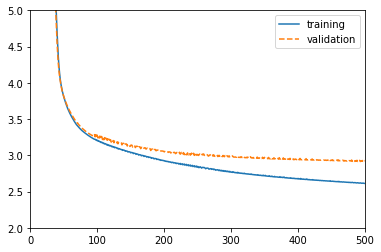

In [190]:
train_loss = nets[2].history[:, 'train_loss']
valid_loss = nets[2].history[:, 'valid_loss']

plt.plot(train_loss, '-', label='training')
plt.plot(valid_loss, '--', label='validation')
plt.ylim(2,5)
plt.xlim(0,500)
plt.legend()
plt.show()

In [191]:
output = nets[2].predict(Xtest)

array([[ 41.982914 , -33.103813 ],
       [ 67.02334  , -32.30083  ],
       [ 75.48336  , -26.652924 ],
       [ 31.56454  , -16.10497  ],
       [ 65.41481  , -33.196575 ],
       [ 50.4262   , -40.424004 ],
       [ 53.09623  , -39.28492  ],
       [ 51.0496   , -40.14241  ],
       [ 35.486618 , -23.988632 ],
       [ 74.36935  , -27.620857 ],
       [ 29.626955 , -10.471446 ],
       [ 34.518826 , -22.695618 ],
       [ 27.950743 ,  -6.2595034],
       [ 46.16822  , -41.129864 ],
       [ 71.863945 , -29.220434 ],
       [ 43.292038 , -34.97463  ],
       [ 61.634888 , -35.375237 ],
       [ 38.502037 , -28.601048 ],
       [ 76.57814  , -25.931702 ],
       [ 30.851223 , -13.2991705],
       [ 75.06059  , -27.16806  ],
       [ 45.73652  , -41.33259  ],
       [ 40.25036  , -31.124245 ],
       [ 38.923172 , -29.15825  ],
       [ 74.457054 , -27.46746  ],
       [ 56.723305 , -37.471146 ],
       [ 71.22625  , -29.62777  ],
       [ 29.348066 ,  -9.910272 ],
       [ 74.449486 ,

In [ ]:
import pandas as pd
df = pd.DataFrame(output)
df.to_csv('../../Marvil_ML-CUP20-TS.csv', index=True, header=False)

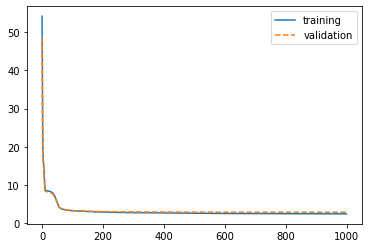

In [17]:
train_loss = nett.history[:, 'train_loss']
valid_loss = nett.history[:, 'valid_loss']

plt.plot(train_loss, '-', label='training')
plt.plot(valid_loss, '--', label='validation')
# plt.ylim(2,5)
# plt.xlim(0,500)
plt.legend()
plt.show()

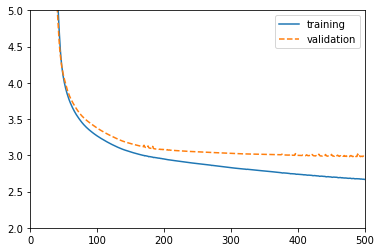

In [253]:
train_loss = nett.history[:, 'train_loss']
valid_loss = nett.history[:, 'valid_loss']

plt.plot(train_loss, '-', label='training')
plt.plot(valid_loss, '--', label='validation')
plt.ylim(2,5)
plt.xlim(0,500)
plt.legend()
plt.show()

In [243]:
from skorch import NeuralNetRegressor

test_net = Net(100, 50, torch.sigmoid)
nett = NeuralNetRegressor(test_net, max_epochs=1000,
                          lr=0.006,
                          batch_size=64,
                          optimizer=optim.SGD,
                          optimizer__momentum=0.8,
                          optimizer__weight_decay=0.0001,
                          optimizer__nesterov = True,
                          criterion=MEE,
#                           train_split=None
#                           callbacks=[EarlyStopping(patience=100)]
                         )
# Training
test_net.apply(init_weights)
nett.fit(Xtrain, ytrain)

prova = nett.predict(Xval)
ris = mean_euclidean_error(prova, yval)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       53.7388       46.9063  0.2703
      2       42.4893       32.1739  0.2462
      3       26.8977       18.8388  0.2625
      4       18.4943       15.9572  0.2702
      5       16.2995       15.2153  0.2890
      6       15.4273       14.5137  0.2492
      7       14.4728       13.3120  0.2619
      8       13.0578       11.6038  0.2930
      9       11.3031        9.8972  0.2983
     10        9.7725        8.7642  0.2399
     11        8.9311        8.3821  0.2625
     12        8.6565        8.2949  0.2733
     13        8.5677        8.2624  0.2605
     14        8.5181        8.2319  0.2502
     15        8.4770        8.1955  0.2786
     16        8.4371        8.1559  0.2410
     17        8.3972        8.1148  0.2558
     18        8.3565        8.0723  0.2628
     19        8.3145        8.0282  0.2961
     20        8.2704        7.9818  0.2872
     21        8.2232        7.9

    132        3.1103        3.2227  0.1246
    133        3.1063        3.2186  0.1003
    134        3.1023        3.2147  0.0823
    135        3.0984        3.2108  0.1006
    136        3.0946        3.2070  0.1220
    137        3.0909        3.2033  0.0970
    138        3.0872        3.1998  0.1079
    139        3.0835        3.1963  0.1066
    140        3.0800        3.1929  0.2355
    141        3.0765        3.1896  0.2532
    142        3.0734        3.1864  0.2437
    143        3.0704        3.1839  0.2702
    144        3.0681        3.1809  0.2450
    145        3.0651        3.1781  0.2754
    146        3.0619        3.1752  0.1626
    147        3.0588        3.1725  0.1037
    148        3.0557        3.1697  0.0979
    149        3.0527        3.1670  0.1049
    150        3.0497        3.1644  0.1037
    151        3.0468        3.1618  0.1207
    152        3.0439        3.1592  0.1417
    153        3.0411        3.1567  0.2359
    154        3.0383        3.1

    269        2.8659        3.0409  0.2445
    270        2.8648        3.0401  0.2447
    271        2.8638        3.0403  0.1710
    272        2.8601        3.0391  0.1091
    273        2.8614        3.0386  0.1441
    274        2.8605        3.0390  0.1054
    275        2.8592        3.0383  0.1035
    276        2.8580        3.0381  0.2819
    277        2.8567        3.0374  0.2924
    278        2.8555        3.0371  0.2452
    279        2.8542        3.0367  0.2331
    280        2.8530        3.0364  0.2526
    281        2.8517        3.0357  0.2564
    282        2.8505        3.0350  0.1128
    283        2.8492        3.0345  0.0828
    284        2.8480        3.0340  0.0809
    285        2.8468        3.0335  0.1116
    286        2.8456        3.0330  0.0961
    287        2.8445        3.0326  0.0841
    288        2.8433        3.0321  0.0884
    289        2.8422        3.0316  0.1082
    290        2.8411        3.0312  0.0853
    291        2.8399        3.0

    408        2.7335        3.0053  0.1041
    409        2.7315        3.0026  0.1046
    410        2.7299        2.9955  0.0821
    411        2.7319        2.9963  0.1083
    412        2.7310        2.9954  0.0847
    413        2.7300        2.9999  0.1028
    414        2.7277        3.0074  0.1000
    415        2.7258        2.9973  0.1062
    416        2.7268        2.9958  0.1006
    417        2.7267        2.9952  0.0876
    418        2.7261        2.9975  0.1147
    419        2.7241        2.9996  0.1209
    420        2.7237        2.9934  0.1034
    421        2.7239        2.9970  0.1033
    422        2.7228        3.0116  0.1021
    423        2.7191        3.0036  0.0884
    424        2.7191        2.9948  0.0784
    425        2.7200        2.9935  0.1042
    426        2.7212        2.9930  0.0947
    427        2.7186        2.9912  0.1157
    428        2.7186        2.9969  0.0975
    429        2.7162        2.9922  0.0908
    430        2.7162        2.9

    574        2.6306        2.9738  0.0998
    575        2.6305        2.9754  0.1000
    576        2.6301        2.9960  0.2142
    577        2.6304        2.9717  0.2260
    578        2.6299        2.9648  0.1820
    579        2.6298        2.9806  0.0875
    580        2.6276        2.9673  0.0900
    581        2.6293        2.9728  0.1164
    582        2.6264        2.9732  0.0885
    583        2.6277        2.9716  0.1004
    584        2.6266        2.9658  0.0846
    585        2.6265        2.9942  0.0796
    586        2.6245        2.9658  0.0813
    587        2.6259        2.9703  0.1038
    588        2.6235        2.9713  0.0882
    589        2.6249        2.9706  0.0909
    590        2.6237        2.9661  0.1107
    591        2.6241        2.9671  0.0887
    592        2.6228        2.9973  0.0945
    593        2.6230        2.9701  0.0913
    594        2.6225        2.9709  0.2366
    595        2.6222        2.9699  0.2395
    596        2.6205        2.9

    739        2.5623        2.9555  0.2532
    740        2.5621        2.9483  0.2191
    741        2.5623        2.9560  0.0777
    742        2.5615        2.9483  0.2584
    743        2.5628        2.9564  0.2366
    744        2.5612        2.9544  0.1430
    745        2.5604        2.9545  0.1517
    746        2.5599        2.9471  0.1781
    747        2.5613        2.9554  0.1033
    748        2.5597        2.9533  0.1272
    749        2.5591        2.9539  0.2924
    750        2.5582        2.9467  0.2856
    751        2.5598        2.9545  0.2909
    752        2.5581        2.9546  0.2357
    753        2.5565        2.9522  0.2632
    754        2.5572        2.9462  0.2051
    755        2.5586        2.9716  0.3013
    756        2.5567        2.9510  0.2609
    757        2.5566        2.9528  0.3218
    758        2.5561        2.9476  0.1622
    759        2.5563        2.9539  0.0914
    760        2.5552        2.9472  0.0924
    761        2.5557        2.9

    902        2.5053        2.9512  0.0810
    903        2.5026        2.9389  0.0775
    904        2.5040        2.9422  0.0837
    905        2.5037        2.9351  0.0939
    906        2.5049        2.9403  0.0737
    907        2.5034        2.9347  0.1688
    908        2.5036        2.9400  0.0889
    909        2.5027        2.9521  0.2428
    910        2.5002        2.9391  0.1762
    911        2.5016        2.9372  0.0905
    912        2.5017        2.9392  0.2239
    913        2.5007        2.9345  0.2570
    914        2.5024        2.9392  0.2762
    915        2.5000        2.9481  0.2243
    916        2.4987        2.9377  0.2133
    917        2.4990        2.9399  0.2281
    918        2.4990        2.9346  0.2346
    919        2.5002        2.9392  0.0841
    920        2.4983        2.9333  0.0975
    921        2.4992        2.9394  0.0905
    922        2.4979        2.9484  0.1319
    923        2.4959        2.9369  0.0767
    924        2.4965        2.9

In [244]:
ris

2.9663548

In [245]:
output = nett.predict(Xtest)

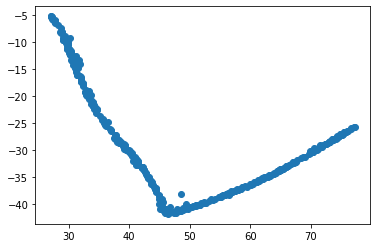

In [246]:
plt.scatter(output[:,0], output[:,1])

In [164]:
import pandas as pd
df = pd.DataFrame(output)
df.to_csv('../../Marvil_ML-CUP20-TS.csv', index=False, header=False)

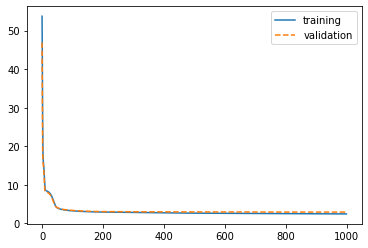

In [249]:
train_loss = nett.history[:, 'train_loss']
valid_loss = nett.history[:, 'valid_loss']

plt.plot(train_loss, '-', label='training')
plt.plot(valid_loss, '--', label='validation')
# plt.ylim(2,5)
# plt.xlim(500,1000)
plt.legend()
plt.show()

In [ ]:
train_loss = nett.history[:, 'train_loss']
valid_loss = nett.history[:, 'valid_loss']

plt.plot(train_loss, '-', label='training')
plt.plot(valid_loss, '--', label='validation')
plt.ylim(2,4.5)
plt.xlim(0,500)
plt.legend()
plt.show()

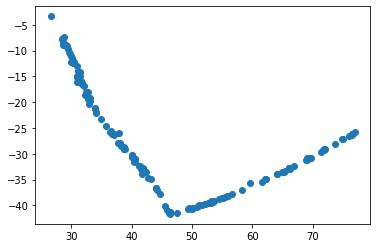

In [70]:
x1 = prova[:,0]
y1 = prova[:,1]
plt.scatter(x1, y1)

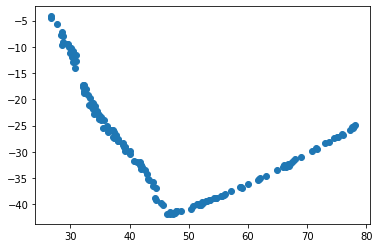

In [71]:
x_real = yval[:,0]
y_real = yval[:,1]
plt.scatter(x_real, y_real)

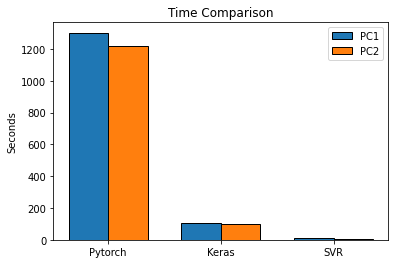

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = ['Pytorch' , 'Keras', 'SVR']
raffaele_tempo = [1303, 108, 10]
luca_tempo = [1222, 99, 2]
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, raffaele_tempo, width, edgecolor='black', label='PC1')
rects2 = ax.bar(x + width/2, luca_tempo, width, edgecolor='black', label='PC2')

ax.set_ylabel('Seconds')
ax.set_title('Time Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.savefig('../../Images/comparison.svg')